In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))



# Create the dataset

In [2]:
from typing import Tuple
import numpy as np

def two_sins_series(
    n_points: int = 70,
    x_start: float = 0.0,
    x_end: float = 1.0,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generates the '2 sins' synthetic series and normalizes to [0, 1].

    f(x) = \frac{sin(5.0x)+0.5sin(8.0x)}{4} + 0.5   
    as per the description in the paper:"""
    x = np.linspace(x_start, x_end, n_points, dtype=float)
    y = ((np.sin(5.0 * x) + 0.5 * np.sin(8.0 * x)) / 4.0) + 0.5

    # normalize to [0, 1] (paper says "(0–1)"; min-max gives [0,1])
    y_min, y_max = float(y.min()), float(y.max())
    if np.isclose(y_max, y_min):
        raise ValueError("Degenerate series: cannot normalize (max == min).")
    y_norm = (y - y_min) / (y_max - y_min)

    return x, y_norm

Generated '2 sins' series with 70 points.


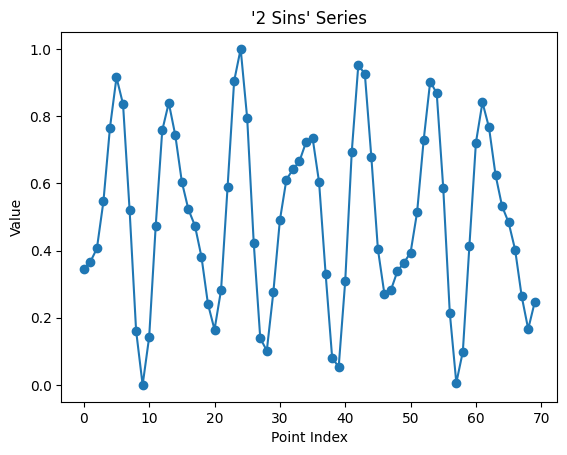

In [3]:

dataset = two_sins_series(n_points=70, x_start=1.0, x_end=10.0)
x, y = dataset
n_points = len(x)
print(f"Generated '2 sins' series with {n_points} points.")
# Visualize the series with x axis showing number of points. 'o' markers for points.
import matplotlib.pyplot as plt
plt.plot(range(n_points), y, marker='o')
plt.title("'2 Sins' Series")
plt.xlabel("Point Index")
plt.ylabel("Value")
plt.show()

In [4]:
from __future__ import annotations

from typing import List, Sequence, Tuple, Union
import numpy as np

ArrayLike1D = Union[np.ndarray, Sequence[float]]

def trend_analyser(segment: np.ndarray, delta: float = 0.0) -> int:
    start = float(segment[0])
    end = float(segment[-1])
    diff = end - start
    if diff > delta:
        return 1
    elif diff < -delta:
        return -1
    else:
        return 0

def paa_segments(y: ArrayLike1D, w: int) -> np.ndarray:
    """
    Split y into w equal-length contiguous segments (requires n % w == 0).

    Returns
    -------
    np.ndarray
        shape (w, n//w)
    """
    y = np.asarray(y, dtype=float).reshape(-1)
    n = len(y)
    if w <= 0:
        raise ValueError("w must be a positive integer.")
    if n % w != 0:
        raise ValueError(f"n={n} not divisible by w={w}. Choose w that divides n.")
    return y.reshape(w, n // w)

def paa_trend_pairs(y: ArrayLike1D, w: int, delta: float = 0.0) -> List[Tuple[float, int]]:
    """
    Compute (PAA mean, trend) per segment.

    Output format:
        [(paa_val, trend), (paa_val, trend), ...]

    where:
        paa_val = mean of the segment
        trend   = +1 if end-start >  delta
                  -1 if end-start < -delta
                   0 otherwise
    """
    segs = paa_segments(y, w=w)
    out: List[Tuple[float, int]] = []
    for seg in segs:
        paa_val = float(np.mean(seg))
        trend = trend_analyser(seg, delta=delta)
        out.append((paa_val, trend))
    return out


In [5]:
# Example: with your two_sins_series
x, y = two_sins_series(n_points=70, x_start=1.0, x_end=10.0)
pairs = paa_trend_pairs(y, w=10, delta=0.02)
pairs[:5], len(pairs)


([(0.5973215357301458, 1),
  (0.4137083590781094, 1),
  (0.44711349425162583, -1),
  (0.5901423025102227, -1),
  (0.5012298830601686, 1)],
 10)

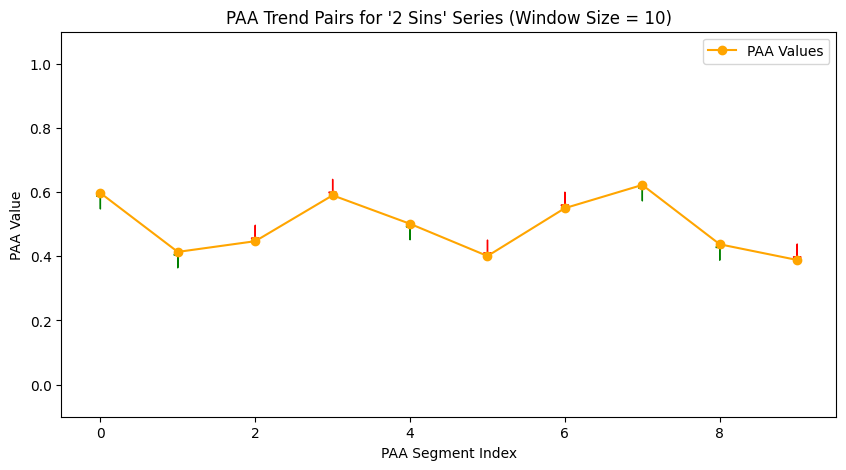

In [6]:

# Visualize the PAA trend pairs
paa_vals, trends = zip(*pairs)
indices = range(len(paa_vals))
plt.figure(figsize=(10, 5))
plt.plot(indices, paa_vals, marker="o", color="orange", label="PAA Values")
for i, trend in zip(indices, trends):
    if trend == 1:
        plt.arrow(i, paa_vals[i] - 0.05, 0, 0.04, head_width=0.1, head_length=0.02, fc='green', ec='green')
    elif trend == -1:
        plt.arrow(i, paa_vals[i] + 0.05, 0, -0.04, head_width=0.1, head_length=0.02, fc='red', ec='red')
plt.title("PAA Trend Pairs for '2 Sins' Series (Window Size = 10)")
plt.xlabel("PAA Segment Index")
plt.ylabel("PAA Value")
plt.ylim(-0.1, 1.1)
plt.legend()
plt.show()

In [7]:
from __future__ import annotations

from typing import Optional, Sequence, Union
import numpy as np
import matplotlib.pyplot as plt

ArrayLike1D = Union[np.ndarray, Sequence[float]]

def plot_paa_trend(
    y: ArrayLike1D,
    w: int,
    delta: float = 0.0,
    x: Optional[ArrayLike1D] = None,
    title: Optional[str] = None,
    marker_size: int = 3,
    show_chords: bool = True,
    show_delta_bands: bool = True,
) -> None:
    y = np.asarray(y, dtype=float).reshape(-1)
    n = len(y)

    if x is None:
        x = np.arange(n, dtype=float)
    else:
        x = np.asarray(x, dtype=float).reshape(-1)
        if len(x) != n:
            raise ValueError(f"x and y must have the same length (got {len(x)} vs {n}).")

    if w <= 0:
        raise ValueError("w must be a positive integer.")
    if n % w != 0:
        raise ValueError(f"n={n} not divisible by w={w}. Choose w that divides n.")

    seg_len = n // w
    segs = paa_segments(y, w=w)
    trends = np.array([trend_analyser(seg, delta=delta) for seg in segs], dtype=int)
    paa_vals = np.array([float(np.mean(seg)) for seg in segs], dtype=float)

    print("Segment trends:", trends.tolist())
    print("Counts:", {k: int((trends == k).sum()) for k in (-1, 0, 1)})
    print("PAA+trend pairs:", list(zip(paa_vals.tolist(), trends.tolist())))

    plt.figure()
    plt.plot(x, y, marker="o", markersize=marker_size)

    for i in range(w):
        start_idx = i * seg_len
        end_idx = (i + 1) * seg_len - 1

        plt.axvline(x[start_idx], linestyle=":", linewidth=1)

        mid_x = (x[start_idx] + x[end_idx]) / 2.0
        top = float(np.max(y[start_idx:end_idx + 1]))
        plt.text(mid_x, top + 0.03, f"{trends[i]}", ha="center", va="bottom")

        if show_chords:
            plt.plot([x[start_idx], x[end_idx]],
                     [y[start_idx], y[end_idx]],
                     linestyle="--", linewidth=1)

        if show_delta_bands and delta > 0:
            plt.hlines([y[start_idx] + delta, y[start_idx] - delta],
                       xmin=x[start_idx], xmax=x[end_idx],
                       linestyles=":", linewidth=1)

    plt.axvline(x[-1], linestyle=":", linewidth=1)
    plt.title(title if title is not None else f"PAA segments (w={w}) with trend labels (delta={delta})")
    plt.xlabel("x" if x is not None else "index")
    plt.ylabel("value")
    plt.tight_layout()
    plt.show()


Segment trends: [1, 1, -1, -1, 1, -1, -1, 1, 1, -1]
Counts: {-1: 5, 0: 0, 1: 5}
PAA+trend pairs: [(0.5973215357301458, 1), (0.4137083590781094, 1), (0.44711349425162583, -1), (0.5901423025102227, -1), (0.5012298830601686, 1), (0.40089838690728874, -1), (0.5501604534198752, -1), (0.6224032940918385, 1), (0.4374186614656393, 1), (0.38855575230660716, -1)]


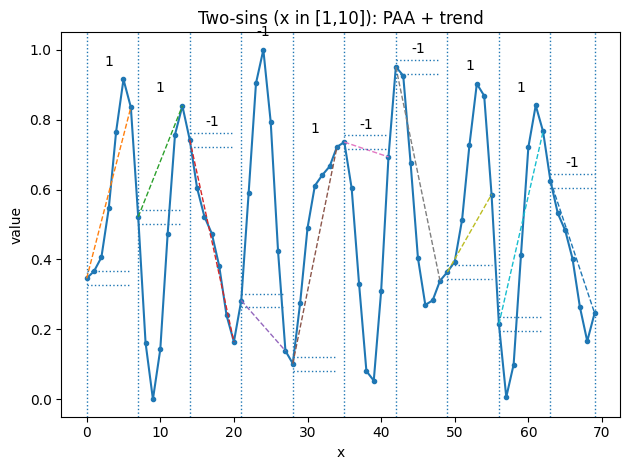

In [8]:
x, y = two_sins_series(n_points=70, x_start=1.0, x_end=10.0)
plot_paa_trend(y, w=10, delta=0.02, title="Two-sins (x in [1,10]): PAA + trend")


In [9]:
from qiskit.primitives import Sampler, Estimator

seed = 2022
shots = 10000

sampler = Sampler()
estimator = Estimator()

/tmp/ipykernel_55486/3259191324.py:6: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
/tmp/ipykernel_55486/3259191324.py:7: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


# Blocks: Serial entangler (CNOT–RZ–CNOT) + angle encoding

In [10]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import ParameterVector

def encode_paa_trend_block(
    num_data_qubits: int,
    paa_label: str = "paa",
    trend_label: str = "trend",
) -> tuple[QuantumCircuit, ParameterVector, ParameterVector]:
    """
    Encode (paa_i, trend_i) on each data qubit i via:
        RY(paa_i) then RZ(trend_i)

    Head qubit is NOT included here.
    """
    qr = QuantumRegister(num_data_qubits, "data")
    qc = QuantumCircuit(qr, name="ENC_PAA_TREND")

    paa = ParameterVector(paa_label, length=num_data_qubits)
    trend = ParameterVector(trend_label, length=num_data_qubits)

    for i in range(num_data_qubits):
        qc.ry(paa[i], qr[i])
        qc.rz(trend[i], qr[i])

    return qc, paa, trend


In [11]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import ParameterVector

def zz_chain_with_head_funnel(
    num_data_qubits: int,
    theta_label: str = "theta",
) -> tuple[QuantumCircuit, ParameterVector]:
    """
    For data qubits q0..q_{N-1} and head q_N:

    For i = 0..N-2:
        CX(q_i -> q_{i+1})
        RZ(theta_i) on q_{i+1}
        CX(q_i -> q_{i+1})
        CX(q_{i+1} -> q_N)
    """
    num_qubits = num_data_qubits + 1  # include head
    qr = QuantumRegister(num_qubits, "data")
    qc = QuantumCircuit(qr, name="ZZ_CHAIN_HEAD")

    theta = ParameterVector(theta_label, length=num_data_qubits - 1)

    head = num_qubits - 1

    for i in range(num_data_qubits - 1):
        qc.cx(qr[i], qr[i + 1])
        qc.rz(theta[i], qr[i + 1])
        qc.cx(qr[i], qr[i + 1])
        qc.cx(qr[i + 1], qr[head])

    return qc, theta


# Ansatz: TwoLocal block

In [14]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import TwoLocal

def twolocal_ansatz(num_qubits: int, label: str = "W") -> tuple[QuantumCircuit, list]:
    qr = QuantumRegister(num_qubits, "data")
    qc = QuantumCircuit(qr, name="ANSATZ")

    w_block = TwoLocal(
        num_qubits,
        rotation_blocks=["rx", "ry", "rz"],
        entanglement_blocks="cx",
        entanglement="linear",
        reps=1,
        parameter_prefix=label,
        insert_barriers=True,
        skip_final_rotation_layer=False,
    )

    qc.append(w_block, qr)
    return qc, list(w_block.parameters)


# Binding PAA vector into the input parameters

In [15]:
from qiskit import QuantumCircuit, QuantumRegister

def build_model(num_data_qubits: int, add_meas: bool = False):
    """
    Full model = PAA+trend feature map (A) + ansatz.
    """
    num_qubits = num_data_qubits + 1  # include head
    qr = QuantumRegister(num_qubits, "data")
    model = QuantumCircuit(qr, name="PAA_TREND_VQC")

    # Feature map
    enc, paa, trend = encode_paa_trend_block(num_data_qubits)
    zz, theta = zz_chain_with_head_funnel(num_data_qubits)

    model.append(enc.to_instruction(), qr[:num_data_qubits])
    model.barrier()
    model.append(zz.to_instruction(), qr)

    # Ansatz
    ans, weights = twolocal_ansatz(num_qubits)
    model.barrier()
    model.append(ans.to_instruction(), qr)

    if add_meas:
        model.measure_all()

    input_params = list(paa) + list(trend)
    weight_params = list(theta) + list(weights)

    return model, input_params, weight_params


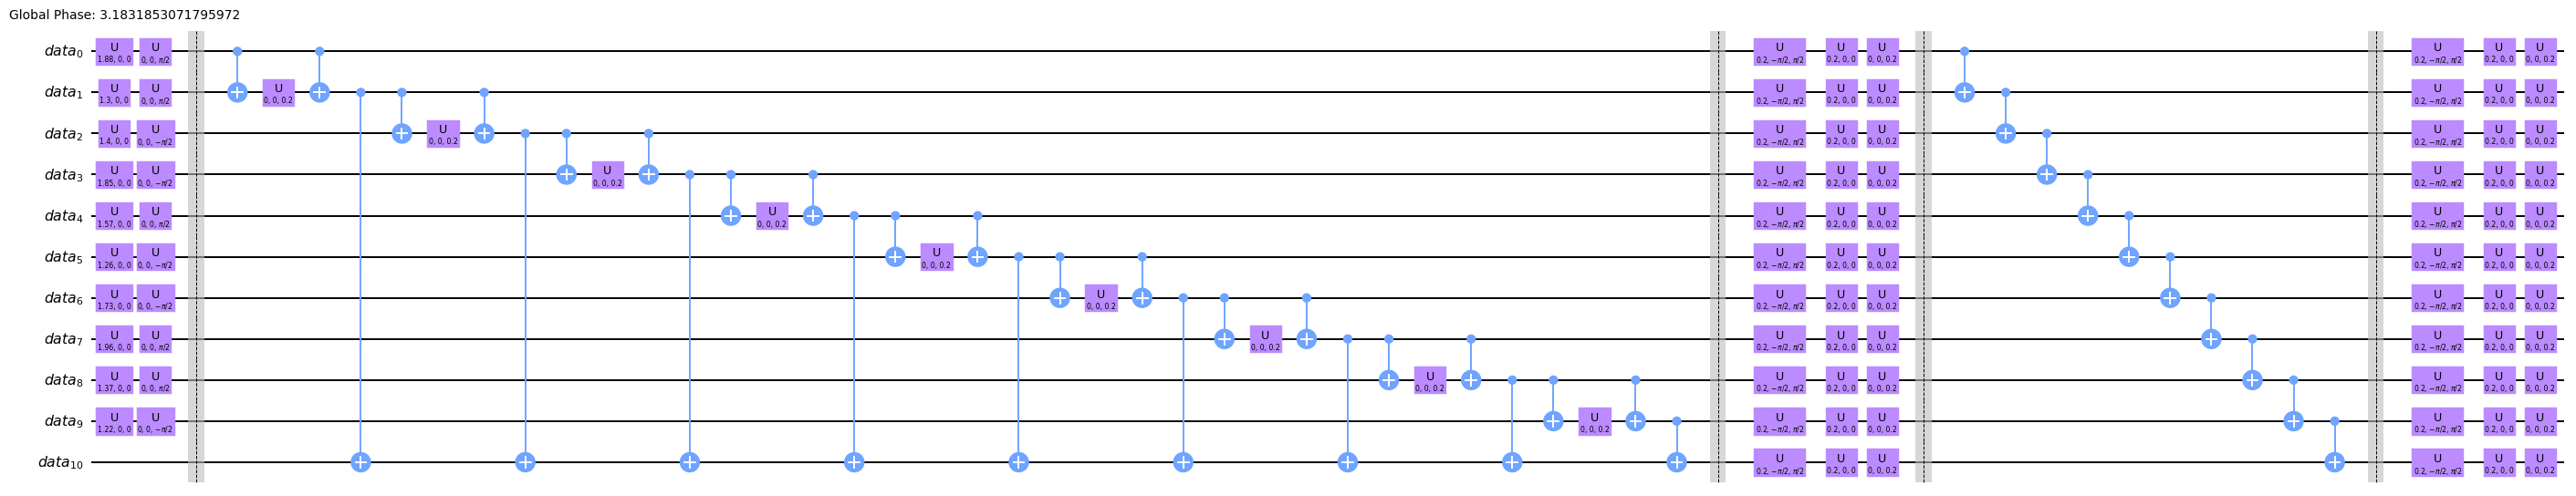

In [20]:
import numpy as np

# --- data -> angles ---
def pairs_to_angles(
    pairs,
    paa_scale=np.pi,
    trend_scale=np.pi / 2,
):
    """
    (paa_i, trend_i) -> (alpha_i, beta_i)
    alpha_i = pi * paa_i
    beta_i  = (pi/2) * trend_i
    """
    paa = np.array([p for p, _ in pairs], dtype=float)
    trend = np.array([s for _, s in pairs], dtype=float)

    return paa_scale * paa, trend_scale * trend


# --- encode one sample into the model ---
num_data_qubits = 10

# build model
qc, input_params, weight_params = build_model(num_data_qubits)

# convert sample to angles
paa_angles, trend_angles = pairs_to_angles(pairs)

# bind inputs (first paa, then trend)
bind_dict = {}
for p, val in zip(input_params[:num_data_qubits], paa_angles):
    bind_dict[p] = float(val)

for p, val in zip(input_params[num_data_qubits:], trend_angles):
    bind_dict[p] = float(val)

# bind weights (example initialization)
for w in weight_params:
    bind_dict[w] = 0.2

# final bound circuit
qc_bound = qc.assign_parameters(bind_dict, inplace=False)

# visualize
qc_full = qc_bound.decompose(reps=10)
qc_full.draw(output="mpl", style="clifford", fold=120, scale=0.7)
